In [1]:
import numpy as np
import collections
from scipy import stats
import scipy
import itertools
import matplotlib.pyplot as plt
from random import sample 
plt.rc('figure', figsize = (8,6))

In [2]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [3]:
def calc_unique(idea_dict, th=1):
    uniq_dict = {}
    idea_count_dict = {}
    
    for key,value in idea_dict.items():
        if key not in uniq_dict:
            uniq_dict[key] = 0
        for idea in value:
            if idea not in idea_count_dict:
                idea_count_dict[idea] = 0
            idea_count_dict[idea] +=1
    
    for key,value in idea_dict.items():
        for idea in value:
            if idea_count_dict[idea]<=th:
                uniq_dict[key]+=1
    
    return uniq_dict,idea_count_dict

In [4]:
def create_E_init(alters_list,n_e = 18):
    E_init = {}
    n_a=int(n_e/3)
    for i in range(n_e):
        followee_ind = (i%n_a,(i+1)%n_a)
        temp_key = 'E_'+str(i+1)
        if temp_key not in E_init:
            E_init[temp_key] = []
        E_init[temp_key] = [alters_list[k] for k in followee_ind]
    return E_init  

In [5]:
def create_exposure_dict(E,alters):
    exposure_dict ={key:[] for key,value in E.items()}
    for key,value in E.items():
        for a in value:
            for i in alters[a]:
                if i not in exposure_dict[key]:
                    exposure_dict[key].append(i)

    return exposure_dict

In [6]:
def create_produced_dict(exposure_dict,alters,stimulation_func='lin',slope = 20):
    produced_dict = {key:[] for key in exposure_dict}
    stimuli_freq = {}
    for key,value in alters.items():
        for idea in value:
            if idea not in stimuli_freq:
                stimuli_freq[idea] = 0
            stimuli_freq[idea] +=1
    total = np.sum([value for key,value in stimuli_freq.items()])
    stimuli_normalized = {key:1-(value/total) for key,value in stimuli_freq.items()}       
        
    for key,value in exposure_dict.items():
        for idea in value:
            M= stimuli_normalized[idea]
            if stimulation_func =="lin":
                countt = int(slope*M)
            elif stimulation_func =="sublin":
                countt = int(slope*np.sqrt(M))
            elif stimulation_func =="suplin":
                countt = int(slope*M*M)
            for i in range(countt):
                produced_dict[key].append(idea+str(i))
    return produced_dict

In [7]:
def rewire(E_init,alters,P_r=0.6):
    uniq_dict,idea_count_dict = calc_unique(alters, th=1)
    stats = collections.Counter(uniq_dict)
    bosses = [k[0] for k in stats.most_common(2)] # get the best two alters
    update_probs = np.random.binomial(size=len(E_init), n=1, p= P_r)
    
    E_updated = {key:value for key,value in E_init.items()}
    for idx, key in enumerate(E_init):
        if update_probs[idx]:
            E_updated[key] = bosses
            
    return E_updated

In [15]:
def generate_alters(alpha_popular, alpha_unpopular,set_len=2, n=6):
    U1 = ['a','b','c','d'] #common 
    U2 = ['n','o','p','q','r','s','t','u','v','w','x','y','z'] #rare
    n_popular = int(n/3) #2
    n_unpopular = n-n_popular
    
    unpopular_fromU1 = np.random.binomial(size=1, n=1, p= alpha_unpopular)
    
    alters_dict={}
    for i in range(n):
        key = 'A'+str(i+1)
        alters_dict[key]=[]
    
    for popular_idx in range(n_popular):    
        for idx_ in range(set_len):
            if np.random.binomial(size=1, n=1, p= alpha_popular): #select from U2
                alters_dict['A'+str(popular_idx+1)].append(sample(U2,1)[0])
            else: 
                alters_dict['A'+str(popular_idx+1)].append(sample(U1,1)[0])
    
    for unpopular_idx in range(n_popular,n):    
        for idx_ in range(set_len):
            if np.random.binomial(size=1, n=1, p= alpha_unpopular): #select from U2
                alters_dict['A'+str(unpopular_idx+1)].append(sample(U2,1)[0])
            else: 
                alters_dict['A'+str(unpopular_idx+1)].append(sample(U1,1)[0])            
                       
    return alters_dict,U1,U2

{'A1': 2, 'A2': 2, 'A3': 0, 'A4': 0, 'A5': 0, 'A6': 0}


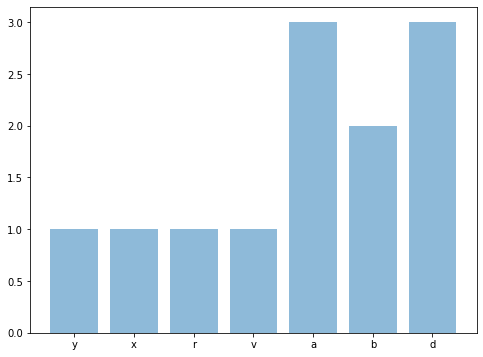

In [27]:
# example of idea histogram of the alters. Some of the ideas are more rare than others
plt.rc('figure', figsize = (8,6))
n_a=6
alters_dict,U1,U2 = generate_alters(1, 0,set_len=2, n=n_a)
stimuli_freq = {}
for key,value in alters_dict.items():
    for idea in value:
        if idea not in stimuli_freq:
            stimuli_freq[idea] = 0
        stimuli_freq[idea] +=1
objects = [key for key,value in stimuli_freq.items()]
counts = [value for key,value in stimuli_freq.items()]
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects)

uniq_dict,_ = calc_unique(alters_dict, th=1)
print(uniq_dict)

In [28]:
def incorporate_overlapping(produced_dict,P_o=0):
    overlapped_produced_dict = {key:[] for key,value in produced_dict.items()}
    if P_o==0:
        ideas_dict = {}
        for key,value in produced_dict.items():
            for idea in value:
                if idea not in ideas_dict:
                    ideas_dict[idea] = []
                ideas_dict[idea].append(key)

        for key,value in ideas_dict.items():
            for id_,ego_ in enumerate(value):
                new_idea = str(key)+"_"+str(id_)
                overlapped_produced_dict[ego_].append(new_idea)
    return overlapped_produced_dict if P_o==0 else produced_dict

Stimulation function: sublin, alter trial 0
Stimulation function: sublin, alter trial 1
Stimulation function: sublin, alter trial 2
Stimulation function: sublin, alter trial 3
Stimulation function: sublin, alter trial 4
Stimulation function: lin, alter trial 0
Stimulation function: lin, alter trial 1
Stimulation function: lin, alter trial 2
Stimulation function: lin, alter trial 3
Stimulation function: lin, alter trial 4
Stimulation function: suplin, alter trial 0
Stimulation function: suplin, alter trial 1
Stimulation function: suplin, alter trial 2
Stimulation function: suplin, alter trial 3
Stimulation function: suplin, alter trial 4


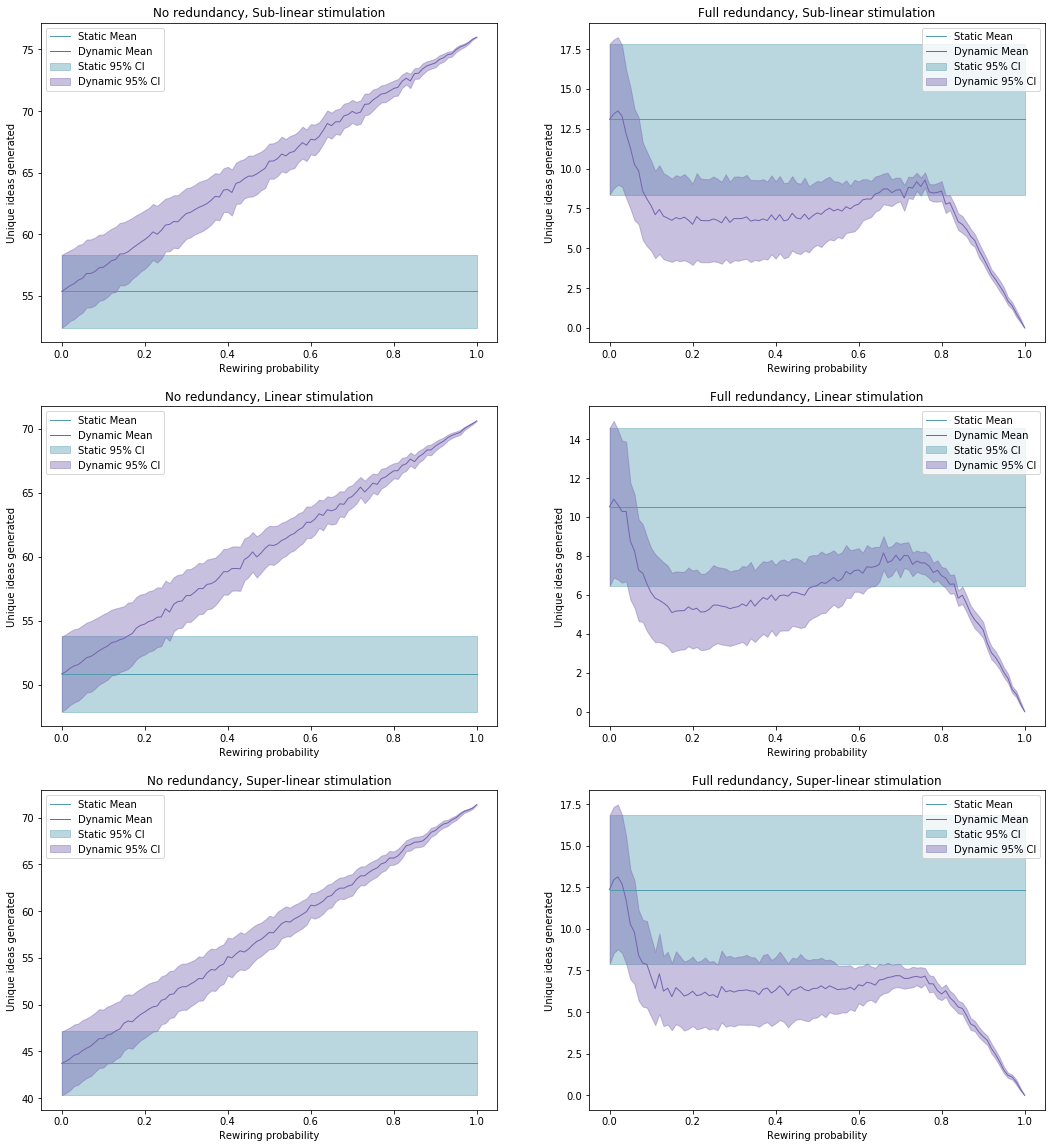

In [44]:
plt.rc('figure', figsize = (18,20))
stimulation_funcs = ['sublin','lin','suplin']
n_a=18 #number of alters
th_ = int(n_a*3*.15) #th_ = 0.15n_ego

# for slope_idx,slope in enumerate(rare_ideas_slope):
for f_idx, stimulation_func in enumerate(stimulation_funcs):
    alter_trial_wise_P_r_dict_list = []
    for alter_trial in range(5):
        print("Stimulation function: "+str(stimulation_func)+", alter trial "+str(alter_trial))
        alters,U1,U2=generate_alters(1, 0,set_len=2, n=n_a)
        alters_list = [key for key,value in alters.items()]
        
        p1 = 0 # probability of generating a completely new idea
        p2 = 1 # probability of generating a derived and valid idea: sufficiently different from trigger idea.
        #prob of generating a derived yet invalid idea: either directly copied from trigger ideas, or not feasible.
        p3 = 0


        P_r_dict = {}
        for P_o in [0,1]: # overlap probability. 0: no overlap, 1: full overlap
            P_r_dict[P_o]={}
            E_static = create_E_init(alters_list,n_e=3*n_a)
            exposure_dict_stat = create_exposure_dict(E_static,alters)
            produced_dict_stat = create_produced_dict(exposure_dict_stat,alters,stimulation_func=stimulation_func)
            overlapped_produced_dict_stat = incorporate_overlapping(produced_dict_stat,P_o=P_o)
            uniq_dict_st, idea_count_dict_st = calc_unique(overlapped_produced_dict_stat, th=th_)

            for P_r in range(0,101,1):
                dynamic_list =[]
                for i in range(25):
                    E_dynamic = rewire(E_static,alters,P_r=P_r/100)
                    exposure_dict_dy = create_exposure_dict(E_dynamic,alters)
                    produced_dict_dy = create_produced_dict(exposure_dict_dy,alters,stimulation_func=stimulation_func)
                    overlapped_produced_dict_dy = incorporate_overlapping(produced_dict_dy,P_o=P_o)
                    uniq_dict_dy, idea_count_dict_dy = calc_unique(overlapped_produced_dict_dy, th=th_)
                    dynamic_list.append([value for key,value in uniq_dict_dy.items()])

                static = [value for key,value in uniq_dict_st.items()]
                dynamic = list(np.mean(np.array(dynamic_list),axis=0))
                P_r_dict[P_o][P_r]={'static':static,'dynamic':dynamic}

        alter_trial_wise_P_r_dict_list.append(P_r_dict)

    dynamic_collection = {}
    static_collection = {}

    for P_o in [0,1]:
        dynamic_collection[P_o] ={}
        static_collection[P_o] ={}
        for P_r in range(0,101,1): # generate a alter_trial summed combo for every P_r
            dynamic_collection[P_o][P_r] = []
            static_collection[P_o][P_r] = []
            for alter_trial in range(len(alter_trial_wise_P_r_dict_list)):
                dynamic_collection[P_o][P_r].append(alter_trial_wise_P_r_dict_list[alter_trial][P_o][P_r]['dynamic'])
                static_collection[P_o][P_r].append(alter_trial_wise_P_r_dict_list[alter_trial][P_o][P_r]['static'])

    dynamic_collection_lumped = {}
    static_collection_lumped = {}
    for P_o in [0,1]:
        dynamic_collection_lumped[P_o] = {}
        static_collection_lumped[P_o] = {}
        for P_r in range(0,101,1):
            dynamic_collection_lumped[P_o][P_r] = list(np.mean(np.array(dynamic_collection[P_o][P_r]),axis=0))
            static_collection_lumped[P_o][P_r] = list(np.mean(np.array(static_collection[P_o][P_r]),axis=0))

    for P_o in [0,1]:
        cc_static_m=[]
        cc_static_l=[]
        cc_static_u=[]
        cc_dynamic_m=[]
        cc_dynamic_l=[]
        cc_dynamic_u=[]
        
        for key,value in dynamic_collection_lumped[P_o].items():
            cc_dynamic_m.append(mean_confidence_interval(value)[0])
            cc_dynamic_l.append(mean_confidence_interval(value)[1])
            cc_dynamic_u.append(mean_confidence_interval(value)[2])

        for key,value in static_collection_lumped[P_o].items():
            cc_static_m.append(mean_confidence_interval(value)[0])
            cc_static_l.append(mean_confidence_interval(value)[1])
            cc_static_u.append(mean_confidence_interval(value)[2])

        h=np.array(cc_static_m)
        i=np.array(cc_static_l)
        j=np.array(cc_static_u)
        k=np.array(cc_dynamic_m)
        l=np.array(cc_dynamic_l)
        m=np.array(cc_dynamic_u)

        plt.subplot(len(stimulation_funcs),2,(f_idx*2)+(P_o+1))
        x = list(np.array([key for key in dynamic_collection_lumped[P_o]])/100)
        plt.plot(x, h, lw = 1, color = '#539caf', alpha = 1, label = 'Static Mean')
        plt.fill_between(x, i, j, color = '#539caf', alpha = 0.4, label = 'Static 95% CI')
        plt.plot(x, k, lw = 1, color = '#7663b0', alpha = 1, label = 'Dynamic Mean')
        plt.fill_between(x, l, m, color = '#7663b0', alpha = 0.4, label = 'Dynamic 95% CI')
        temp_title = ["Sub-linear","Linear","Super-linear"]
        if P_o==0:
            plt.title("No redundancy, "+str(temp_title[f_idx])+" stimulation")
        else:
            plt.title("Full redundancy, "+str(temp_title[f_idx])+" stimulation")
        plt.xlabel("Rewiring probability")
        plt.ylabel("Unique ideas generated")
        plt.legend(loc = 'best') 
# plt.savefig('plots/15pc/simulation_result_'+str(n_a)+'.eps', format='eps')